<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/downloadDicomAndConvertNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook does the first step in the split workflow on Terra**
DICOM files are downloaded from IDC and converted to NIFTI files with dcm2niix or plastimatch. Whenever there are multiple NIFTI files for a series, such series are prohibited from continuing to Inference. A CSV file is created with a list of such series.

Please cite:

Li X, Morgan PS, Ashburner J, Smith J, Rorden C. (2016) The first step for neuroimaging data analysis: DICOM to NIfTI conversion. J Neurosci Methods. 264:47-56.

Shackleford, James A., Nagarajan Kandasamy and Gregory C. Sharp. “Plastimatch—An Open-Source Software for Radiotherapy Imaging.” (2014).



###**Installing Packages**

In [1]:
%%capture
#Installing dcm2niix and pigz
!apt-get install dcm2niix pigz lz4

In [2]:
%%capture
#Installing plastimatch
!apt-get install plastimatch 

In [3]:
%%capture
#install s5cmd
!wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
!tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
!rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
!mv s5cmd /usr/local/bin/s5cmd

###**Importing Packages**

In [4]:
import os
import sys
import time
import pandas as pd
from pathlib import Path
import shutil
import glob
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import matplotlib.pyplot as plt
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Fri Apr  7 17:42:40 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###**Parameters for papermill**

In [5]:
converterType='dcm2niix'
csvFilePath=''

###**For local testing**

In [6]:
!wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
csvFilePath = glob.glob('*.csv')[0]


--2023-04-07 17:42:40--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139861 (137K) [text/plain]
Saving to: ‘batch_1.csv’

batch_1.csv         100%[===================>] 136.58K  --.-KB/s    in 0.03s   

2023-04-07 17:42:41 (5.01 MB/s) - ‘batch_1.csv’ saved [139861/139861]



###**Reading CSV File containing s5cmd Urls**

In [7]:
start_time = time.time()
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')

read in 0.018195390701293945  seconds


In [8]:
SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()

###**Defining Functions**

In [9]:
#Creating Directories
if converterType.lower()=='dcm2niix':
  try:
    shutil.rmtree('dcm2niix')
  except OSError:
    pass
  os.mkdir('dcm2niix')
else:
  try:
    shutil.rmtree('plastimatch')
  except OSError:
    pass
  os.mkdir('plastimatch')

In [10]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.

  """
  try:
    shutil.rmtree(f'idc_data/{series_id}')
  except OSError:
    pass
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [11]:
def convert_dicom_to_nifti(series_id):
  if converterType.lower()=='dcm2niix':
    try:
      shutil.rmtree(f'dcm2niix/{series_id}')
    except OSError:
      pass
    os.mkdir(f'dcm2niix/{series_id}')

    !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  else:
    try:
      shutil.rmtree(f'plastimatch/{series_id}')
    except OSError:
      pass
    os.mkdir(f'plastimatch/{series_id}')
    """
    Make sure to check the s5cmd urls for the destination directory and 
    plastimatch input directory must be changed accordingly
    dcm2niix, however, checks upto depth 5 to find DICOM files

    """
    !plastimatch convert --input /{curr_dir}/idc_data/{series_id} --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz


  try:
      shutil.rmtree('idc_data')
  except OSError:
      pass
  os.mkdir('idc_data')

In [12]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb,  disk_usage_all, disk_total

In [13]:
def download_and_process_series(series_id):
    log = pd.DataFrame({'SeriesInstanceUID': [series_id]})

    start_time = time.time()
    download_dicom_data( series_id)
    download_time = time.time() - start_time

    log['download_time'] = download_time

    start_time = time.time()
    convert_dicom_to_nifti(series_id)
    convert_dicom_to_nifti_time = time.time() - start_time

    log['NiftiConverter_time'] = convert_dicom_to_nifti_time

    global runtime_stats
    runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)



###**Downloading and Converting**

Copying files from IDC buckets..
Done in 1.93765 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 181 DICOM file(s)
Convert 181 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.11872245252939435071116658934_1_OPA_GE_LSPR16_STANDARD_330_2.5_120_80_58.2_1.4_20000102000000_2 (512x512x181x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.11872245252939435071116658934_1_OPA_GE_LSPR16_STANDARD_330_2.5_120_80_58.2_1.4_20000102000000_2.nii"
Conversion required 7.144577 seconds (0.456055 for core code).


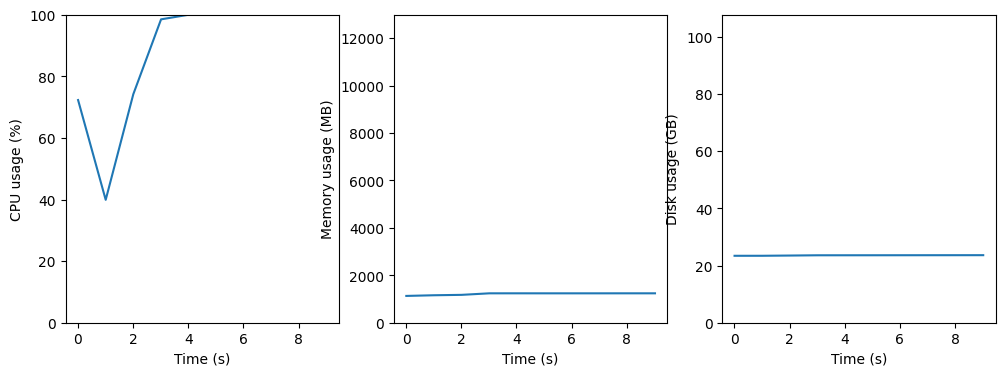

Copying files from IDC buckets..
Done in 1.72578 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 115 DICOM file(s)
Convert 115 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2 (512x512x115x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2.nii"
Conversion required 5.266407 seconds (0.244947 for core code).


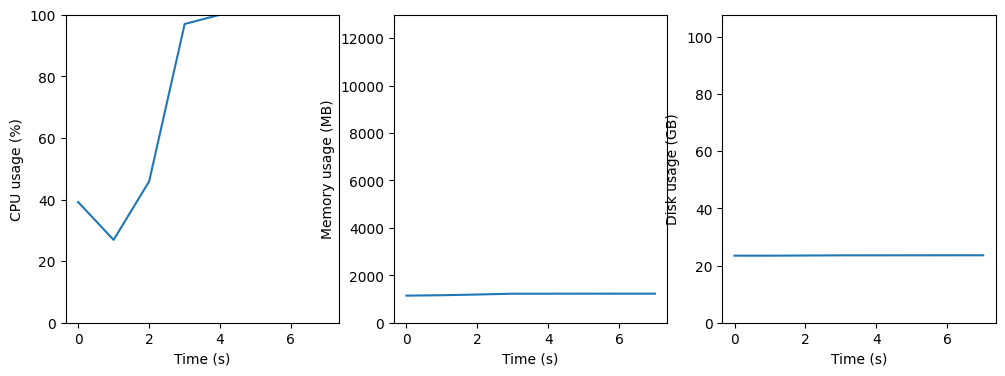

Copying files from IDC buckets..
Done in 2.0337 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 135 DICOM file(s)
Convert 135 DICOM as //content/dcm2niix/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243_0_OPA_GE_LSQX_STANDARD_360_2.5_120_na_na_na_19990102000000_2 (512x512x135x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243_0_OPA_GE_LSQX_STANDARD_360_2.5_120_na_na_na_19990102000000_2.nii"
Conversion required 4.107725 seconds (0.305403 for core code).


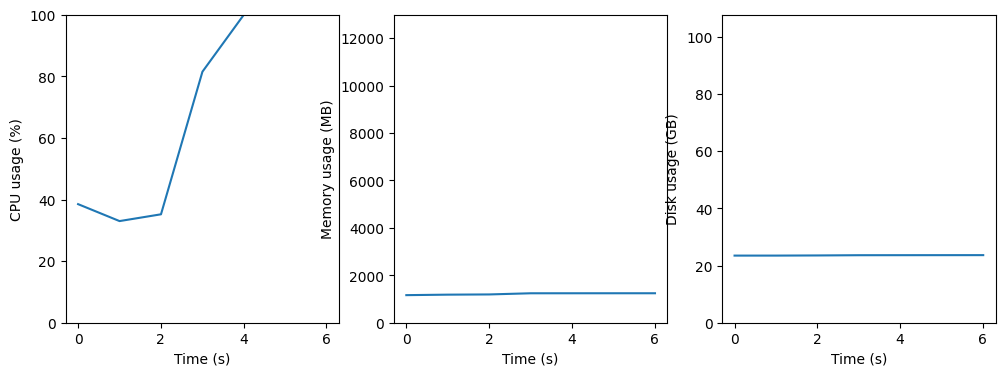

Copying files from IDC buckets..
Done in 2.25328 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 191 DICOM file(s)
Convert 191 DICOM as //content/dcm2niix/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696_0_OPA_GE_LSQX_STANDARD_352_2.5_120_64_0.1_1.5_19990102000000_2 (512x512x191x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696_0_OPA_GE_LSQX_STANDARD_352_2.5_120_64_0.1_1.5_19990102000000_2.nii"
Conversion required 7.149069 seconds (0.484127 for core code).


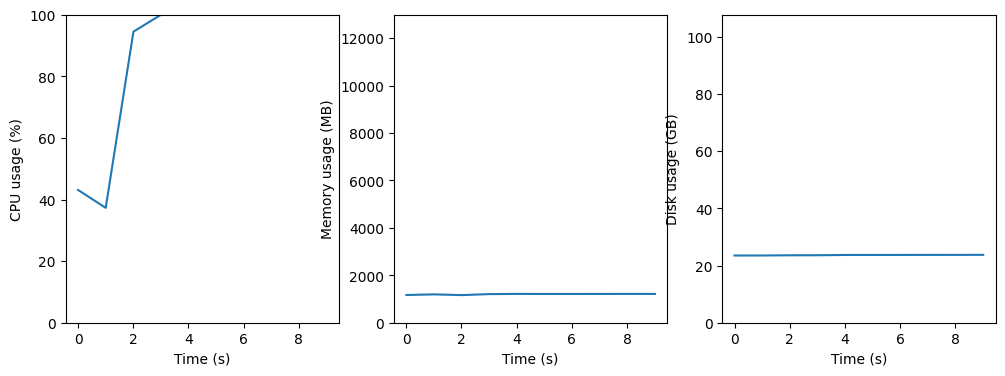

Copying files from IDC buckets..
Done in 1.83522 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 128 DICOM file(s)
Convert 128 DICOM as //content/dcm2niix/1.2.840.113654.2.55.142419057730651121165090739113900499978/1.2.840.113654.2.55.142419057730651121165090739113900499978_2_OPA_GE_LSQX_BONE_360_2.5_120_72_0.1_1.5_20010102000000_3 (512x512x128x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.142419057730651121165090739113900499978/1.2.840.113654.2.55.142419057730651121165090739113900499978_2_OPA_GE_LSQX_BONE_360_2.5_120_72_0.1_1.5_20010102000000_3.nii"
Conversion required 4.783357 seconds (0.267576 for core code).


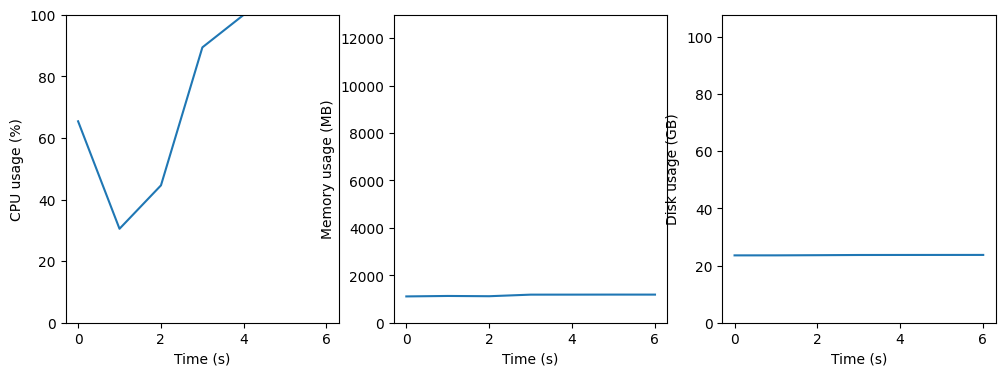

Copying files from IDC buckets..
Done in 1.82604 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 122 DICOM file(s)
Convert 122 DICOM as //content/dcm2niix/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706_0_OPA_GE_LSQX_STANDARD_350_2.5_120_na_na_na_19990102000000_2 (512x512x122x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706_0_OPA_GE_LSQX_STANDARD_350_2.5_120_na_na_na_19990102000000_2.nii"
Conversion required 3.555916 seconds (0.254275 for core code).


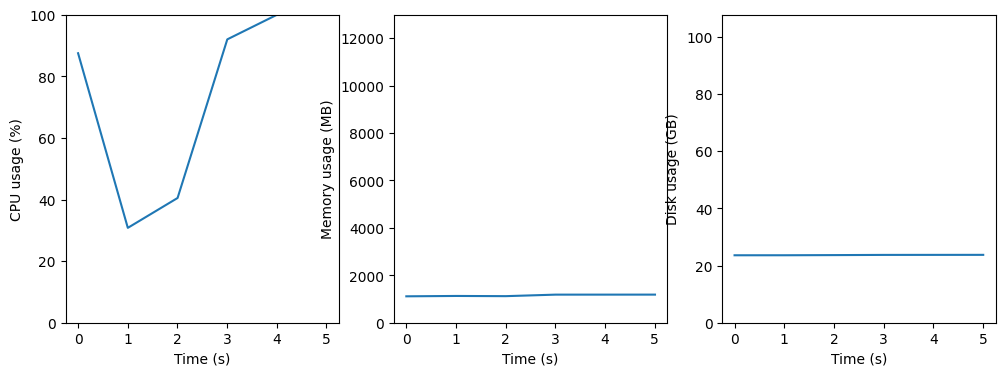

Copying files from IDC buckets..
Done in 1.8294 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 139 DICOM file(s)
Convert 139 DICOM as //content/dcm2niix/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397_1_OPA_GE_LSQX_STANDARD_360_2.5_140_40_0_1.5_20000102000000_2 (512x512x139x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397_1_OPA_GE_LSQX_STANDARD_360_2.5_140_40_0_1.5_20000102000000_2.nii"
Conversion required 5.695389 seconds (0.301073 for core code).


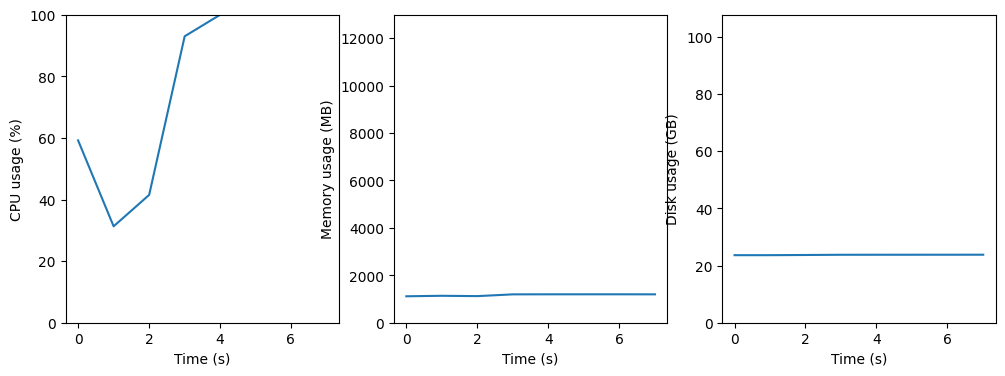

Copying files from IDC buckets..
Done in 1.93004 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 112 DICOM file(s)
Convert 112 DICOM as //content/dcm2niix/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510_0_OPA_GE_LSQX_STANDARD_310_2.5_120_64_0.1_1.5_19990102000000_2 (512x512x112x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510_0_OPA_GE_LSQX_STANDARD_310_2.5_120_64_0.1_1.5_19990102000000_2.nii"
Conversion required 3.259291 seconds (0.229462 for core code).


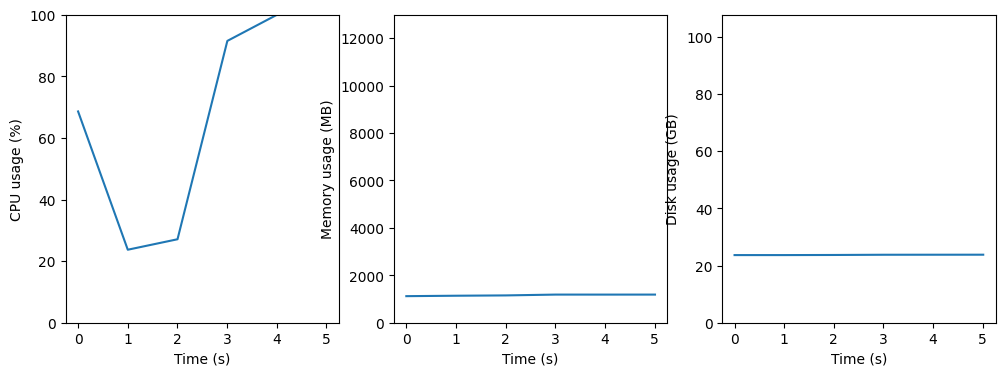

Copying files from IDC buckets..
Done in 2.73214 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 158 DICOM file(s)
Convert 158 DICOM as //content/dcm2niix/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332_1_OPA_GE_LSQX_STANDARD_360_2.5_120_48_0_1.5_20000102000000_2 (512x512x158x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332_1_OPA_GE_LSQX_STANDARD_360_2.5_120_48_0_1.5_20000102000000_2.nii"
Conversion required 4.872344 seconds (0.385838 for core code).


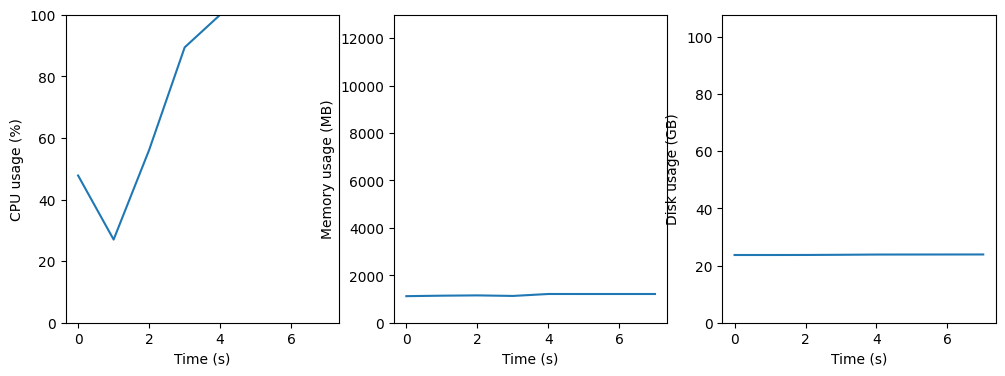

Copying files from IDC buckets..
Done in 2.42856 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 130 DICOM file(s)
Convert 130 DICOM as //content/dcm2niix/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482_0_OPA_GE_HSQX_BONE_340_2.5_120_56_0.1_1.5_19990102000000_3 (512x512x130x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482_0_OPA_GE_HSQX_BONE_340_2.5_120_56_0.1_1.5_19990102000000_3.nii"
Conversion required 4.571593 seconds (0.284183 for core code).


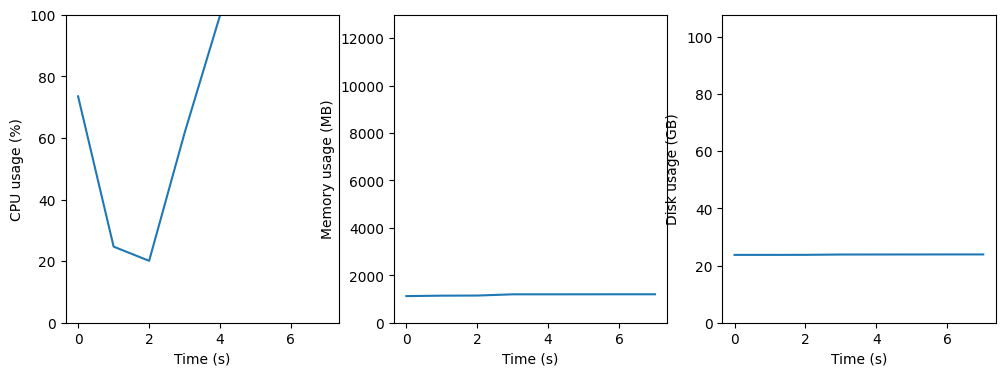

Copying files from IDC buckets..
Done in 2.43793 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 128 DICOM file(s)
Convert 128 DICOM as //content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2 (512x512x128x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2.nii"
Conversion required 3.655592 seconds (0.283280 for core code).


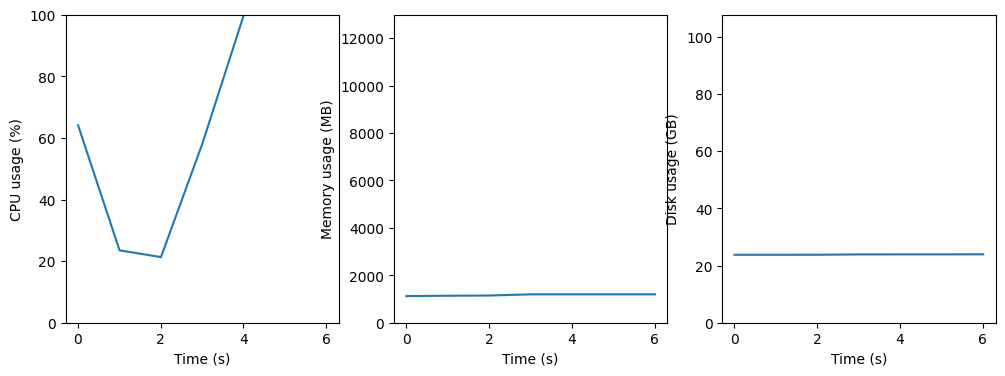

Copying files from IDC buckets..
Done in 2.0374 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 180 DICOM file(s)
Convert 180 DICOM as //content/dcm2niix/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215_1_OPA_GE_LSQX_STANDARD_360_2.5_120_64_0.1_1.5_20000102000000_2 (512x512x180x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215_1_OPA_GE_LSQX_STANDARD_360_2.5_120_64_0.1_1.5_20000102000000_2.nii"
Conversion required 6.558725 seconds (0.464667 for core code).


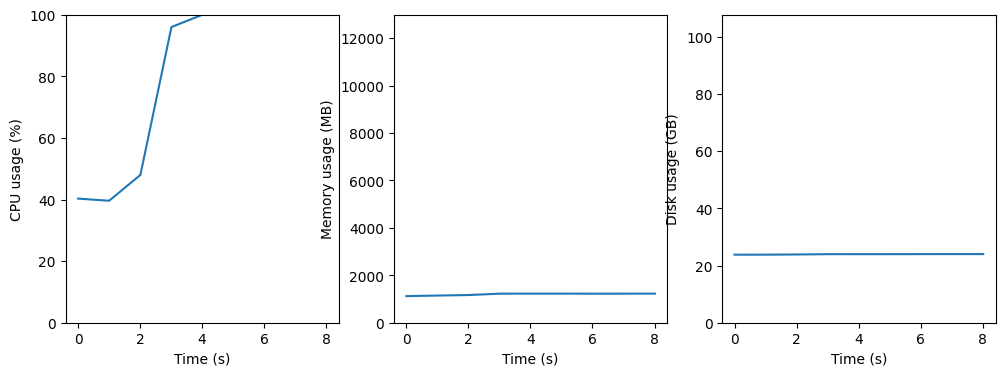

In [14]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','download_time',
                                      'NiftiConverter_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 'disk_usage_all', 'disk_total'
                                      ])

if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(download_and_process_series, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total    

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###**Monitoring for dcm2niix Errors**

In [15]:
import os
import csv

def check_dcm2niix_errors(path):
    for series_id in os.listdir(path):
        series_id_path = os.path.join(path, series_id)
        if os.path.isdir(series_id_path):
            num_files = len([f for f in os.listdir(series_id_path) if os.path.isfile(os.path.join(series_id_path, f))])
            if num_files > 1:
                print(f'Found one more than one nifti for the {series_id}')
                with open('dcm2niix_errors.csv', 'a') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow([series_id])
                shutil.rmtree(f'dcm2niix/{series_id}')


In [16]:
if converterType.lower()=='dcm2niix':
    check_dcm2niix_errors(f'/{curr_dir}/dcm2niix')

###**Compressing Output Files**


In [17]:
try:
  os.remove('downloadDicomAndConvertNiftiFiles.tar.lz4')
except OSError:
  pass
start_time = time.time()
!tar cvf - {curr_dir}/{converterType} | lz4 > downloadDicomAndConvertNiftiFiles.tar.lz4
archiving_time = time.time() - start_time


tar: Removing leading `/' from member names
/content/dcm2niix/
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2.nii.gz
/content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/
/content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2.nii.gz
/content/dcm2niix/1.2.840.113654.2.55.14382674871619950799472325766084940706/
/content/dcm2niix/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706_0_OPA_GE_LSQX_STANDARD_350_2.5_120_na_na_na_19990102000000_2.nii.gz
/content/dcm2niix/1.2.840.113654.2.55.2439904514060064033314258096328

###Utilization Metrics

In [18]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['csv_read_time']=read_time
runtime_stats['archiving_time']=archiving_time

try:
  os.remove('downloadDicomAndConvertUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv downloadDicomAndConvertUsageMetrics.lz4
runtime_stats

Compressed 5751 bytes into 3671 bytes ==> 63.83%


,SeriesInstanceUID,download_time,NiftiConverter_time,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total,csv_read_time,archiving_time
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529...,2.058770,7.221560,"[[[72.3, 39.9, 74.2, 98.5, 100.0, 100.0, 100.0...","[[[1130.0078125, 1157.9296875, 1175.0078125, 1...",[12985.546875],"[[[23.406475067138672, 23.41266632080078, 23.4...",107.715084,0.018195,1.657548
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401...,1.854355,5.418658,"[[[39.2, 26.9, 45.9, 97.0, 100.0, 100.0, 100.0...","[[[1141.7421875, 1159.30859375, 1189.02734375,...",[12985.546875],"[[[23.446796417236328, 23.44860076904297, 23.5...",107.715084,0.018195,1.657548
2,1.2.840.113654.2.55.10087518978221069034420730...,2.162270,4.171655,"[[[38.5, 33.0, 35.2, 81.5, 100.0, 100.0, 100.0]]]","[[[1162.6484375, 1183.41015625, 1192.52734375,...",[12985.546875],"[[[23.473587036132812, 23.47730255126953, 23.5...",107.715084,0.018195,1.657548
3,1.2.840.113654.2.55.11304038617854784357127123...,2.385904,7.279220,"[[[43.1, 37.3, 94.5, 100.0, 100.0, 100.0, 100....","[[[1168.1015625, 1195.11328125, 1163.95703125,...",[12985.546875],"[[[23.507625579833984, 23.510208129882812, 23....",107.715084,0.018195,1.657548
4,1.2.840.113654.2.55.14241905773065112116509073...,1.958781,4.918760,"[[[65.4, 30.5, 44.6, 89.4, 100.0, 100.0, 100.0]]]","[[[1108.88671875, 1128.27734375, 1117.3046875,...",[12985.546875],"[[[23.554035186767578, 23.558998107910156, 23....",107.715084,0.018195,1.657548
5,1.2.840.113654.2.55.14382674871619950799472325...,1.954345,3.671979,"[[[87.5, 30.8, 40.5, 92.0, 100.0, 100.0]]]","[[[1113.26171875, 1128.45703125, 1120.19921875...",[12985.546875],"[[[23.589447021484375, 23.59442901611328, 23.6...",107.715084,0.018195,1.657548
6,1.2.840.113654.2.55.14660159465432299498263001...,1.954758,5.816813,"[[[59.2, 31.3, 41.5, 93.0, 100.0, 100.0, 100.0...","[[[1114.68359375, 1135.55859375, 1121.9453125,...",[12985.546875],"[[[23.620906829833984, 23.623493194580078, 23....",107.715084,0.018195,1.657548
7,1.2.840.113654.2.55.15480970559124215907525360...,2.056644,3.377385,"[[[68.6, 23.7, 27.1, 91.5, 100.0, 100.0]]]","[[[1119.99609375, 1138.140625, 1151.42578125, ...",[12985.546875],"[[[23.65456771850586, 23.654727935791016, 23.6...",107.715084,0.018195,1.657548
8,1.2.840.113654.2.55.18530918259180563451786039...,2.866429,4.995440,"[[[47.8, 27.0, 56.1, 89.4, 100.0, 100.0, 100.0...","[[[1119.6640625, 1140.2578125, 1152.56640625, ...",[12985.546875],"[[[23.68297576904297, 23.682979583740234, 23.6...",107.715084,0.018195,1.657548
9,1.2.840.113654.2.55.21661400233888873398735052...,2.556123,4.704929,"[[[73.5, 24.7, 20.1, 61.8, 100.0, 100.0, 100.0...","[[[1122.203125, 1141.078125, 1145.58984375, 11...",[12985.546875],"[[[23.723648071289062, 23.723644256591797, 23....",107.715084,0.018195,1.657548
